# Tutorial: EC-MS data analysis


*Data required*: available for download [here](https://zenodo.org/record/8400063)

This tutorial is to show the most advanced tools to date for ixdat analysis of EC-MS data.

It is based on the data analysis done for Spectro Inlets Application Note #2 - Quantification

There are three parts:

- Importing, plotting and exporting data
- Analyzing EC-MS calibrations
- Using EC-MS calibrations

Before you dive into the tutorial, download the data available at https://zenodo.org/record/8400063 and save it into a folder on your computer. Then adjust the `data_dir` variable in the first code cell to point to that folder. If you save the data contents in the same folder as this jupyter notebook, use:

`data_dir = Path(".")`


Importing, plotting, and exporting
===========================

First, we import and plot the dataset we would like to calibrate. 

importing ixdat v0.2.7.dev1 from C:\Users\Søren\git\ixdat\src\ixdat\__init__.py


C:\Users\Søren\git\ixdat\src\ixdat\plotters\base_mpl_plotter.py:61: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes = [plt.subplot(gs[0:3, 0])]
C:\Users\Søren\git\ixdat\src\ixdat\plotters\ms_plotter.py:131: UserWarning: Can't convert original unit 's' to new unit 'None'. Plotting using original unit 'None' with unit_factor=1 (one).
  x_unit_factor, x_unit = self._get_x_unit_factor(x_unit, "s")


[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='Voltage [V]'>,
 None,
 <Axes: ylabel='Current [mA]'>]

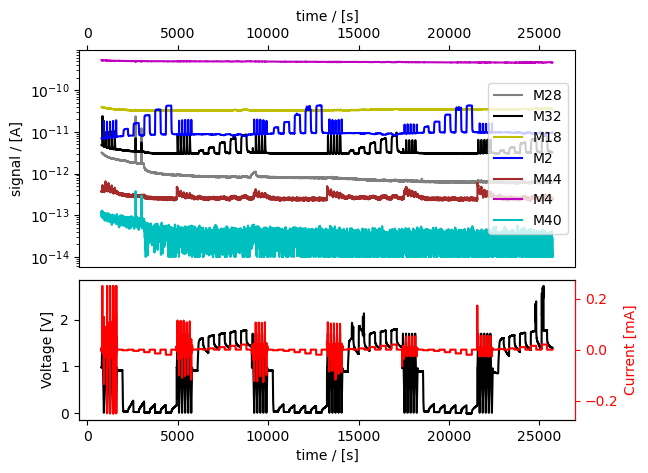

In [1]:
from pathlib import Path
from ixdat import Measurement

# adjust this to point to your data:
data_dir = Path.home() / "Dropbox/ixdat_resources/tutorials_data/23J02_ec_ms_quantification/Zenodo_8400063"

meas_zilien = Measurement.read(data_dir / "2022-07-19 10_02_32 HER_OER_calibration.tsv", reader="zilien")

meas_zilien.plot()

That was a lot. Let's zoom in on an interesting part.

Tip: if you're using a backend for matplotlib that returns scalable plots (not Jupyter notebooks), you can easily zoom into your plot to find the timestamps at start and end of the part you find interesting. A left mouse click into the plot will print the time where the mouse is pointing to. A right click at a different point following a left click will print the start and end as well as length of the timespan in between. 

[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='Voltage [V]'>,
 None,
 <Axes: ylabel='Current [mA]'>]

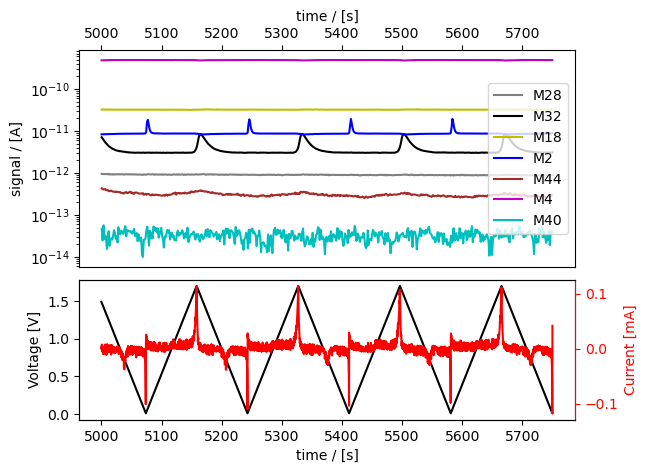

In [2]:
meas_zilien.plot(tspan=[5000, 5750])

# help(meas.plot)  # This shows a full list of customization arguments to the plot function

The EC data looks a bit noisy - let's use the EC data as saved by ECLab here instead. First we import the MS data only from the Zilien data file:

Note, if you use Zilien vs. 2.6.0 or higher, Zilien will export the same data as saved by ECLab, so this will no longer be necessary.

In [3]:
ms_meas = Measurement.read(data_dir / "2022-07-19 10_02_32 HER_OER_calibration.tsv", reader="zilien", technique="MS")
ms_meas.replace_series("Ewe/V", None)
ms_meas.replace_series("I/mA", None)

Then we import the electrochemistry data from the text files exported by ECLab. You can do so either separately and then use the ``+`` operator to add them or use the method ``read_set`` to import and combine all files with a specified suffix in a specified folder + name-prefix. The latter can be a lot more convenient if a number of different EC files should be imported.

In [4]:
# import separately and add
cvs_her_meas = Measurement.read(data_dir / "HER_OER_calibration_01_01_CVA.mpt", reader="biologic")
cps_her_meas = Measurement.read(data_dir / "HER_OER_calibration_01_02_CP.mpt", reader="biologic")
cvs_oer_meas = Measurement.read(data_dir / "HER_OER_calibration_01_03_CVA.mpt", reader="biologic")
cps_oer_meas = Measurement.read(data_dir / "HER_OER_calibration_01_04_CP.mpt", reader="biologic")
ecdata_meas = cvs_her_meas + cps_her_meas + cvs_oer_meas + cps_oer_meas
print(ecdata_meas)

# or read and add them all together
ecdata_meas = Measurement.read_set(data_dir, suffix=".mpt", reader="biologic")
print(ecdata_meas)

ECMeasurement(id=5, name='HER_OER_calibration_01_01_CVA.mpt AND HER_OER_calibration_01_02_CP.mpt AND HER_OER_calibration_01_03_CVA.mpt AND HER_OER_calibration_01_04_CP.mpt')
ECMeasurement(id=10, name='HER_OER_calibration_01_01_CVA.mpt AND HER_OER_calibration_01_02_CP.mpt AND HER_OER_calibration_01_03_CVA.mpt AND HER_OER_calibration_01_04_CP.mpt')


As you can see from the measurement names printed above, both options result in the same combined ``ECMeasurement`` object.

Finally, we combine EC data with the MS data and plot it again, to check the quality of the EC data.

[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='Ewe/V'>,
 None,
 <Axes: ylabel='raw_current'>]

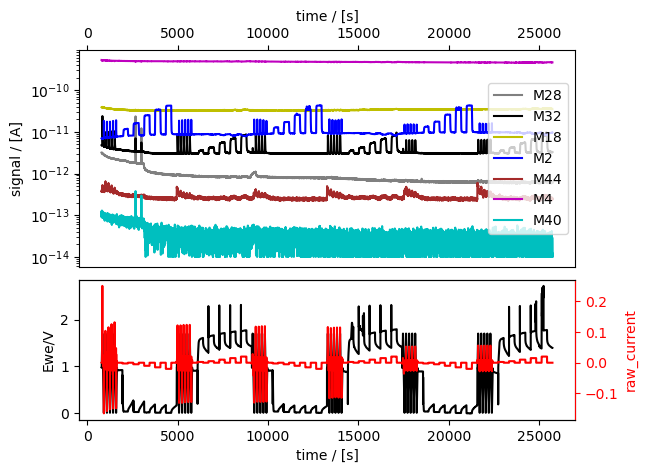

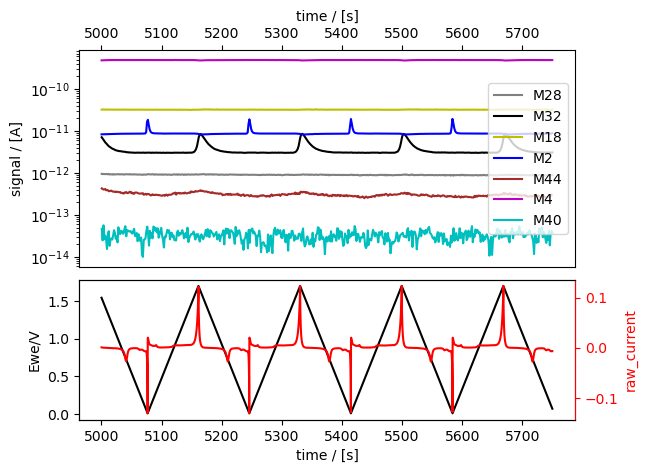

In [5]:
meas = ms_meas + ecdata_meas

meas.plot()
meas.plot(tspan=[5000, 5750])

Now that looks better! Let's export that bit so we can share it with someone without exceeding an attachment limit:

In [6]:
meas_part = meas.cut(tspan=[5000, 5750])
meas_part.export("the_good_bit.csv")

ixdat can of course read the files it exports:

skipping the following line:
ixdat version = 0.2.7.dev1

skipping the following line:
backend_name = BackendBase(none, address=none)



[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='Ewe/V'>,
 None,
 <Axes: ylabel='<I>/mA'>]

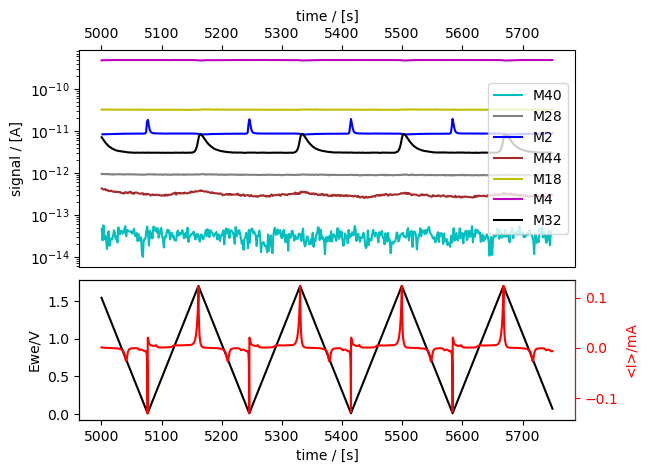

In [7]:
meas_loaded = Measurement.read("the_good_bit.csv", reader="ixdat", technique="EC-MS")

meas_loaded.plot_measurement()

Calibrations
==========

EC-MS calibration
-------------------------

Now, we analyze EC-MS calibration measurements. The code is taken from here:

https://github.com/ScottSoren/pyCOox_public/blob/main/paper_I_fig_S1/paper_I_fig_S1.py

We know the geometric area of the electrode, so we can normalize the current: it's a 5mm diameter disk, area = 0.196 cm^2
We used an RHE reference electrode, so we assume that the potential difference between our reference electrode and the RHE potential is zero. We did not determine the Ohmic drop, but we will assume that it was 0 (even though that is not entirely correct), to demonstrate how we can calibrate for it. 

[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='$U_{RHE}$ / [V] $_{ohm. corr.}$'>,
 None,
 <Axes: ylabel='J / [mA cm$^{-2}$]'>]

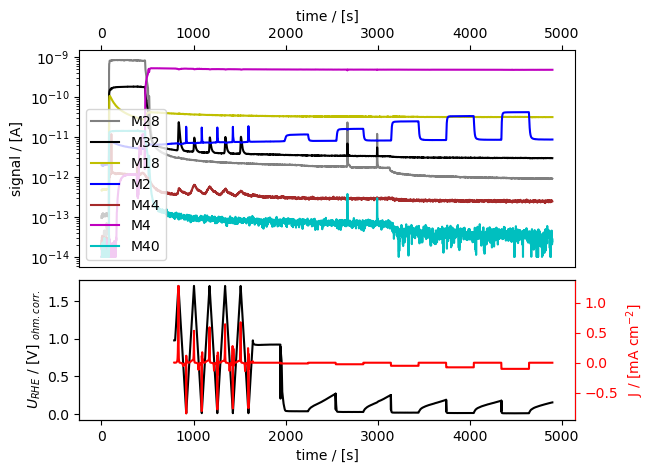

In [8]:
meas.calibrate(RE_vs_RHE=0, A_el=0.196, R_Ohm=0)
# select the first hydrogen calibration and plot with calibrated EC data
meas.plot(tspan=[0,4900])

There is some data here before the hydrogen calibration measurement starts; let's shift t=0 to the right, to when the CPs start.

In [9]:
meas.tstamp += meas["M2"].t[0] + 1700

The raw data is easily plotted with the plot_measurement function, which doesn't only create a figure, but also returns
a list of three axes for (i) ms, (ii) potential, and (iii) current. See ``help(meas.plot_measurement)`` for customization. 

We will be adding to these axes later to indicate the timespans used for the calibrations.

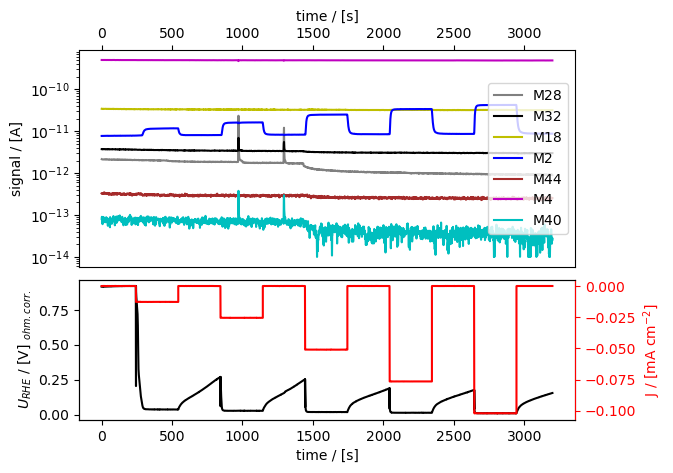

In [10]:
axes_a = meas.plot_measurement(tspan=(0, 3200))

Now, this is a standard EC-MS plot, which is in itself not bad. Still, sometimes one might like to change something about it, let's say the size of the axis labels, the position of the legend, or the dimensions of the figure. To do this, we can name the figure by getting it via the first axis, which then allows us to modify the plot like any regular matplotlib plot. This only works if the plot has not been printed yet, so we need to define ``axes_a`` again at the beginning. Let's make the plot wider, as an example:

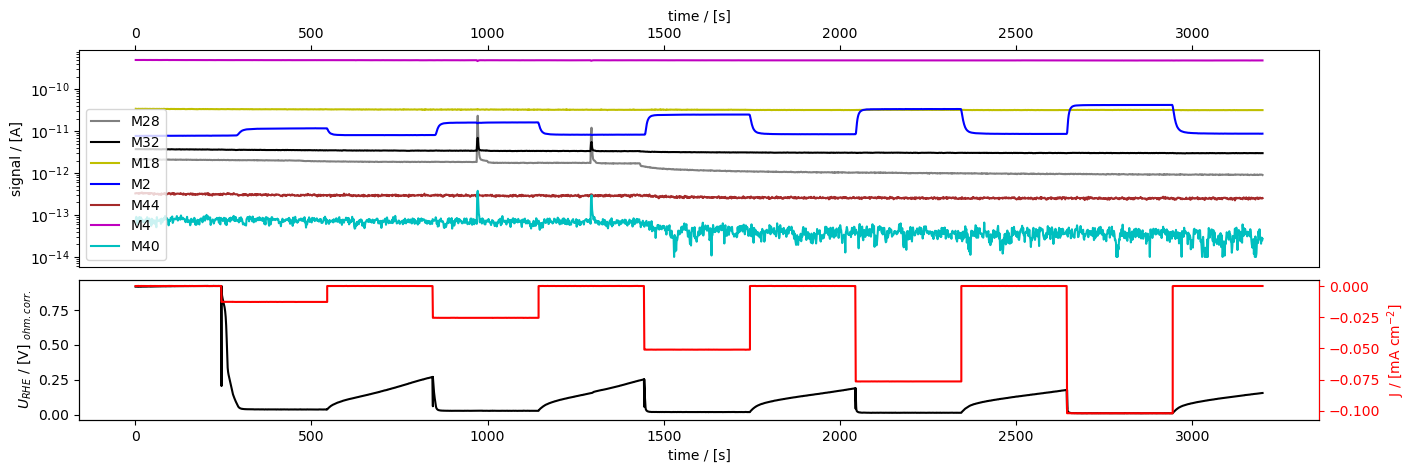

In [11]:
axes_a = meas.plot_measurement(tspan=(0, 3200))
fig_a = axes_a[0].get_figure()  # name the figure by getting it via the first axis.
fig_a.set_figwidth(
    fig_a.get_figwidth() * 2.5
)  # make it 2.5 times as wide as it is tall

Great! Now we're ready to use this data to calibrate for H2 at m/z=2. For this we use the ixdat method ``ecms_calibration_curve``, which automatically selects and integrates M2 signal and electrochemical current in the given timespans. 

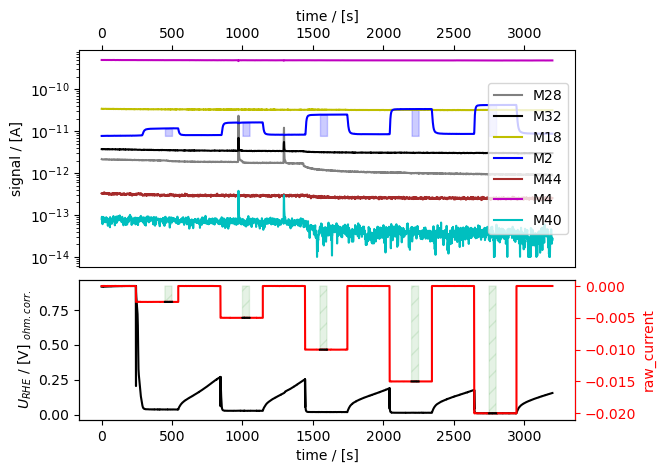

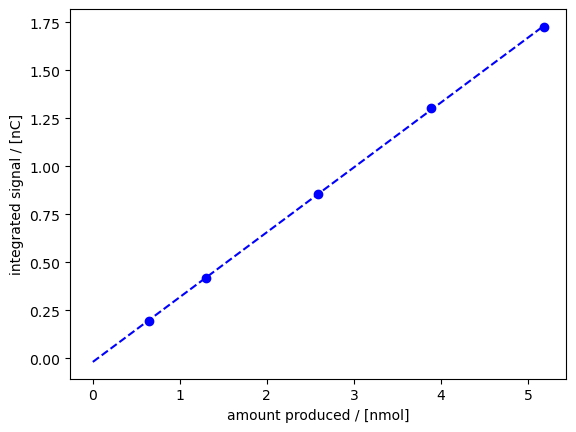

In [12]:
# redefine this axis, so we can use it here (since Jupyter doesn't update already printed plots).
axes_a = meas.plot_measurement(tspan=(0, 3200), J_name="raw_current") 
# calculate the calibration factor
cal_result_H2, ax_b = meas.ecms_calibration_curve(
    mol="H2",
    mass="M2",
    n_el=-2, # remember to use the correct sign: minus for reduction reactions, plus for oxidation reactions
    tspan_list=[(450, 500), (1000, 1050), (1550, 1600), (2200, 2250), (2750, 2800)],  # timespans of H2 evolution
    tspan_bg=(0, 100),
    ax="new",
    axes_measurement=axes_a, # to highlight the integrated areas on the plot defined above
    return_ax = True # if True, returns the calibration curve axis as a second element
) 
# NOTE, due to a yet-to-be-resolved issue with coplotting of the integrated current, we are plotting raw current 
# again here (as specified with "J_name" in plot_measurement above)

Because we asked for ``return_ax``, two arguments are returned:
The first, which we call ``cal_result_H2``, is a ``MSCalResult`` for H2.
The second, which we call ``ax_H2``, is the axis where it plots the calibration curve.
As we asked for ``axes_measurement``, to be plotted on ``axes_a``, the areas that were integrated are highlighted on that axes.

The attribute ``cal_result_H2.F`` is the slope of the calibration curve, which is the sensitivity factor in C/mol.
(Note that this calibration_curve works with integrals rather than simply the rates. The latter is not (yet?) implemented in ixdat.)

In [13]:
print(cal_result_H2)  # prints: MSCalResult(name="H2@M2", mol="H2", mass="M2", F=0.34)

# This is the first of several MSCalResults, which we will collect in this list:
cal_results = [cal_result_H2]

# save the figure:
fig_b = ax_b.get_figure()
fig_b.savefig("hydrogen_calibration.png")  # you can use eg .svg instead for vector graphics.

MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.33788342934494986)


Tip: instead of selecting the time spans manually, you can also use the option of passing a ``selector_name (str)`` (Name of selector which identifies the periods of steady electrolysis for automatic selection of timespans of steady electrolysis. E.g. ``"selector"`` or ``"Ns"`` for biologic EC data) and a ``selector_list`` instead of the ``tspan_list``. Note that you need to have information on the different parts of the EC data in your measurement data to take advanatge of this. If you used a Zilien version < 2.6.0 when running the measurement, this requires that you import the EC data from the ECLab using the ``"biologic"`` reader, as we did above for ``meas``.

First, let's figure out what we should pass to selector list. To this end, we can plot the selector we want to use in our regular EC-MS plot, for example instead of the current: 

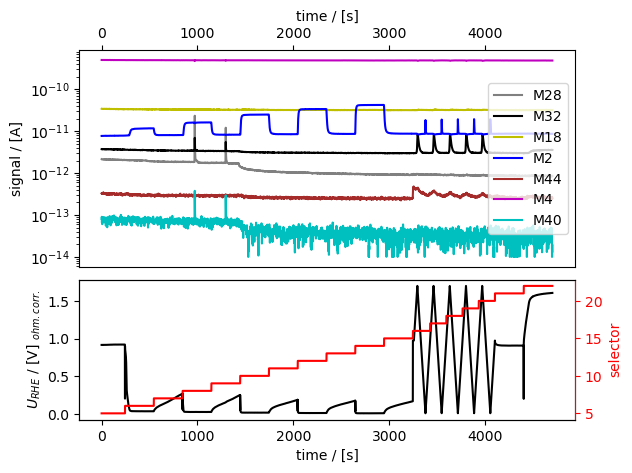

In [14]:
axes_a2 = meas.plot_measurement(tspan=(0, 4700), J_name="selector")

Following tspans were selected for calibration: [[1944.5646467208862, 2244.564239025116], [2544.564631462097, 2844.5642240047455], [3144.5646164417267, 3444.5642087459564], [3744.5646011829376, 4044.564193725586], [4344.564585924149, 4644.564178466797]]
MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.33788342934494986)


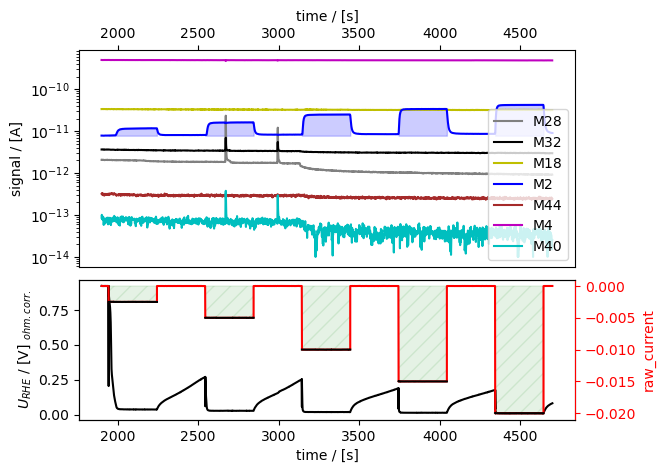

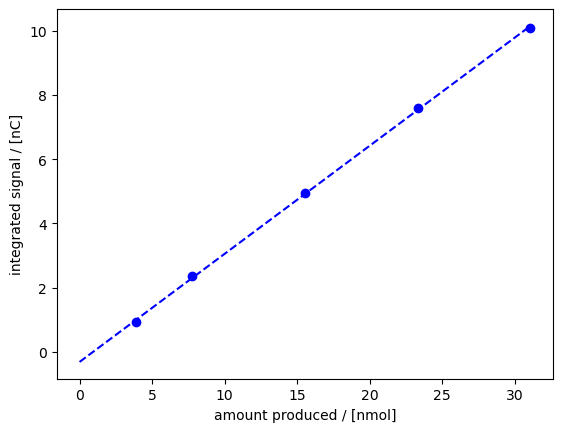

In [15]:
# since we want to see a different part of the measurement now, let's shift the tstamp back to the original one
meas.tstamp += meas["M2"].t[0]
# redefine this axis, so we can use it here (since Jupyter doesn't update already printed plots).
axes_a2 = meas.plot_measurement(tspan=(1900, 4700), J_name="raw_current")
# calculate the calibration factor
cal_result_H2_selector, ax_b2 = meas.ecms_calibration_curve(
    mol="H2",
    mass="M2",
    n_el=-2, # remember to use the correct sign: minus for reduction reactions, plus for oxidation reactions
    selector_name="selector",
    selector_list=[6,8,10,12,14],  # sections of H2 evolution
    tspan_bg=(1800, 1900),
    ax="new",
    axes_measurement=axes_a2, # to highlight the integrated areas on the plot defined above
    return_ax = True # if True, returns the calibration curve axis as a second element
)
print(cal_result_H2)  # prints: MSCalResult(name="H2@M2", mol="H2", mass="M2", F=0.34)

Now, let's do the same for oxygen. First, let's find the right section of the measurement and plot it, so we can find the ``tspan``.

[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='$U_{RHE}$ / [V] $_{ohm. corr.}$'>,
 None,
 <Axes: ylabel='J / [mA cm$^{-2}$]'>]

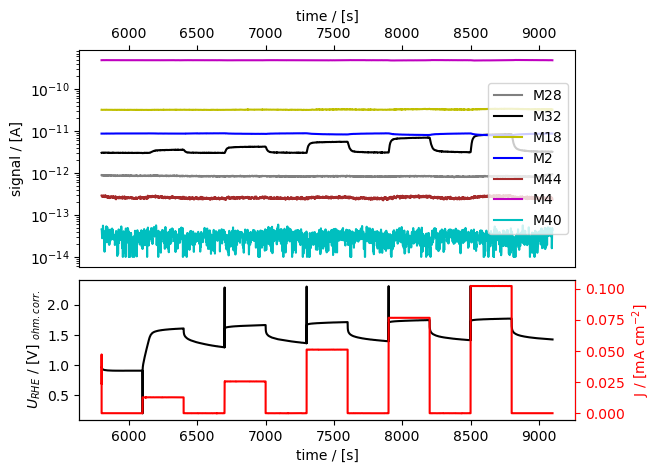

In [16]:
meas.plot(tspan=[5800,9100])

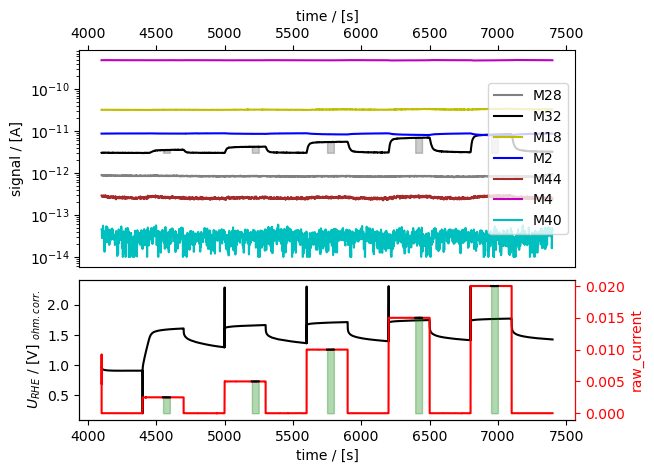

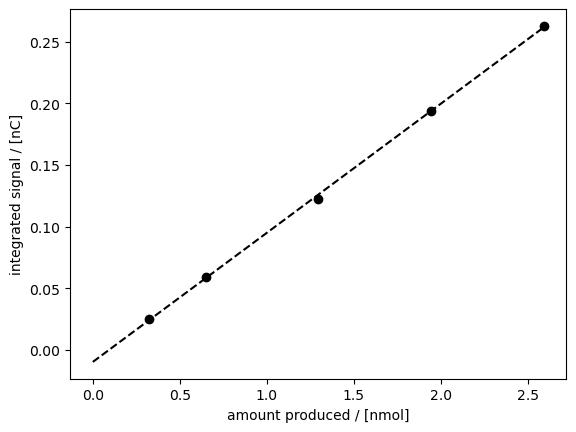

In [17]:
# we like changing the time stamp, so let's do this again
meas.tstamp += meas["M2"].t[0] + 1700
# let's define an axes variable, so we can use it to plot the integrated areas.
axes_c = meas.plot_measurement(tspan=(4100, 7400), J_name="raw_current") 
# calculate the calibration factor
cal_result_O2, ax_d= meas.ecms_calibration_curve(
    mol="O2",
    mass="M32",
    n_el=4, # remember to use the correct sign: minus for reduction reactions, plus for oxidation reactions
    tspan_list=[(4550, 4600), (5200, 5250), (5750, 5800), (6395, 6445), (6950, 7000)],  # timespans of O2 evolution
    tspan_bg=(4150, 4250),
    ax="new",
    axes_measurement=axes_c, # to highlight the integrated areas on the plot defined above
    return_ax = True # if True, returns the calibration curve axis as a second element
)

In [18]:
print(cal_result_O2)  # prints: MSCalResult(name="O2@M32", mol="O2", mass="M32", F=0.10)

# Let's add this to our list of MSCalResult objects:
cal_results.append(cal_result_O2)

# save the figure:
fig_d = ax_d.get_figure()
fig_d.savefig("oxygen_calibration.png")  # you can use eg .svg instead for vector graphics.

MSCalResult(name=O2@M32, mol=O2, mass=M32, F=0.10473806185860812)


Congratulations! We have now calibrated for hydrogen and oxygen, using electrochemical calibration. However, this approach limits our calibration to those products that we can produce electrochemically with close to 100% faradaic efficiency.
Instead, we can take advantage of the gas system of the EC-MS and directly introduce calibration gases to the chip.

Gas calibration
---------------------

Let's first do this for hydrogen and oxygen to compare with the results from the electrochemical gas calibration. 

First we need to import the data, of course. The Zilien datafile doesn't contain any EC data in this case, which confuses the reader - we therefore specify ``technique="MS"``.

<Axes: xlabel='time / [s]', ylabel='signal / [A]'>

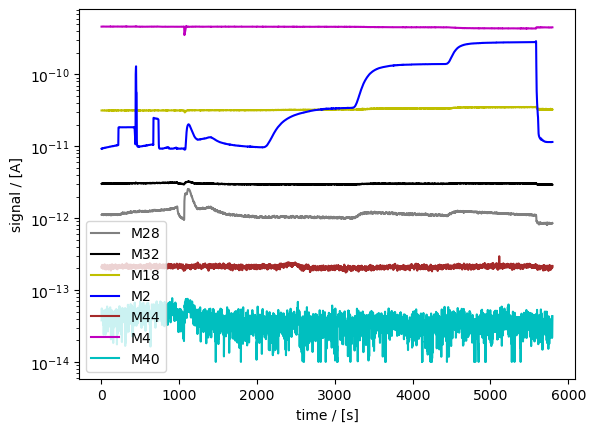

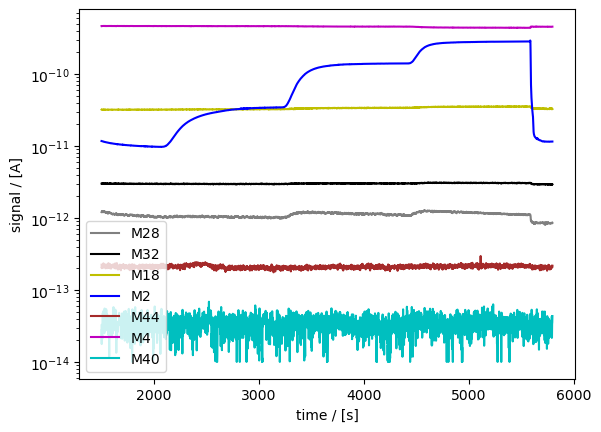

In [19]:
meas_gascal_H2 = Measurement.read(data_dir / "2022-07-20 11_24_43 gas_cal_high_H2.tsv", reader="zilien", technique="MS")

meas_gascal_H2.plot()
# We don't need the first 1500s of the measurement, where the signals fluctuate a bit while pumping and flushing the gas lines
meas_gascal_H2 = meas_gascal_H2.cut(tspan=[1500, 6000])
meas_gascal_H2.plot()

Now, the gas calibration works a bit differently than the EC-MS calibration, as it relies on knowing the flux of molecules into the MS for the inlet used. Therefore, the calibration is not done for a specific measurement, but rather for an ``MSInlet`` object, which requires a slightly different sytnax.

Let's first define the inlet object:  ``ixdat``'s default MS inlet is a Spectro Inlets EC-MS chip. The chip object contains information about the inlet, such as it's dimensions, the temperature and pressure, as well as functions for calculating the molar flux of a pure gas (the carrier gas) to the capillary, and for using this flux to calculate a sensitivity factor. 

(In principle, the chip's capillary size should be calibrated, but this usually only changes the results by a few percent, and is not yet implemented in ixdat.)

In [20]:
from ixdat.techniques.ms import MSInlet

chip = MSInlet() 
# chip = MSInlet(T=300, p=20000) #optional: select T (in Kelvin) and p (in Pa); will use 298.15 K and 10000 Pa if not specified

Now we can use the method ``gas_flux_calibration_curve`` to do a gas calibration. Note, this method relies on the calculation of the flux of the carrier gas through the capillary and assumes that this flux will not be affected by the change in gas composition due to the analytes. This assumption likely holds as long as the gas concentration is <10% (better <1%), but is ideally only used for small analyte concentrations. A new, more powerful method is in development and will be introduced in a separate tutorial soon. 

C:\Users\Søren\git\ixdat\src\ixdat\techniques\ms.py:488: DeprecationWarning: The argument named 'chip' in method 'MSMeasurement._gas_flux_calibration_curve' is deprecated, its last supported version being 0.2.6:
* It will become hard deprecated, raising exceptions rather than issuing warnings, from version 0.3

See instructions below on how to update your code to avoid this message:
Use `inlet` instead. Or consider using `siq_gas_flux_calibration_curve` with the `spectro_inlets_quantification` package.
  return self._gas_flux_calibration_curve(


MSCalResult(name=H2_M2_gas, mol=H2, mass=M2, F=0.3191356304426368)


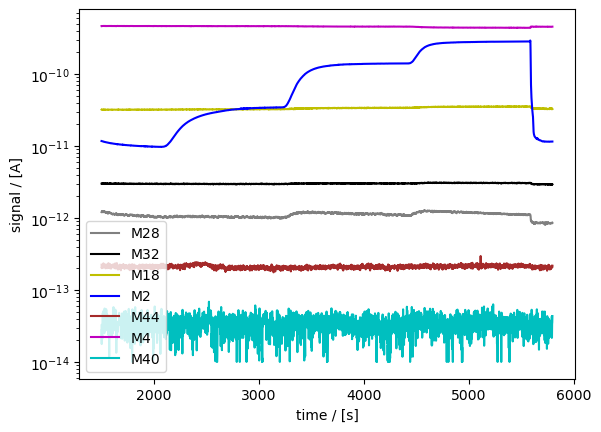

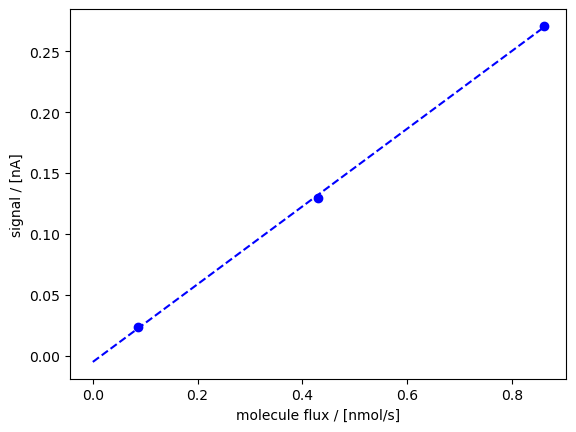

In [21]:
axes_e = meas_gascal_H2.plot_measurement()

cal_H2_2, ax_f = meas_gascal_H2.gas_flux_calibration_curve(
    inlet=chip,  # the mass spec inlet used in the calibration experiment
    mol="H2",  # the molecule to calibrate
    mass="M2",  # the mass to calibrate at
    tspan_list=[
        [2900, 3100],
        [4200, 4400],
        [5200, 5500],
         ], # the timespans to average the signal over
    carrier_mol="He", # the molecule that is used to calculate the total flux through the capillary
    mol_conc_ppm=[10000, 50000, 100000], # the concentration of the analyte at the timespans given above in ppm
    tspan_bg=[1900, 2000], # the timespan for background subtraction (optional)
    return_ax=True, # whether to return the calibration curve
    #axes_measurement=axes_e # the axis on which to indicate what signal is used with a thicker line  
    #-> this introduces an error into the data analysis (defines that mol_conc_ppm = 10^6) FIXME!! 
)

cal_H2_2.name = "H2_M2_gas"  # so that it doesn't clash with the EC-MS calibration.

# add these gas calibrations to the list:
print(cal_H2_2) 
cal_results.append(cal_H2_2)

Great! Now that we know how to do this, we can also do it for our oxygen and ethylene calibrations.

MSCalResult(name=O2_M32_gas, mol=O2, mass=M32, F=0.09198714869342346)
MSCalResult(name=C2H4@M26, mol=C2H4, mass=M26, F=0.08057166014411676)


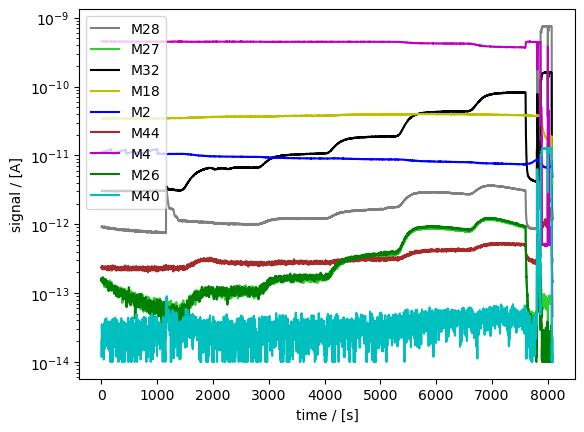

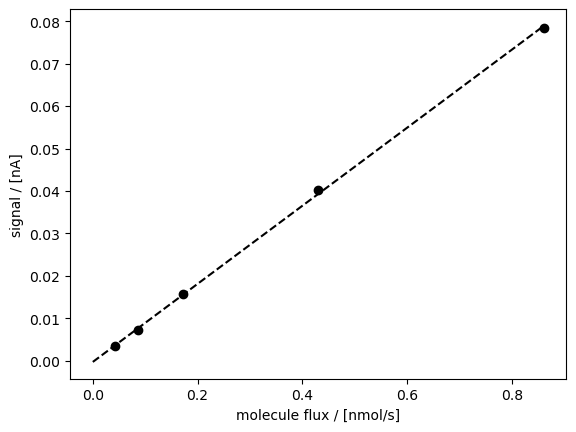

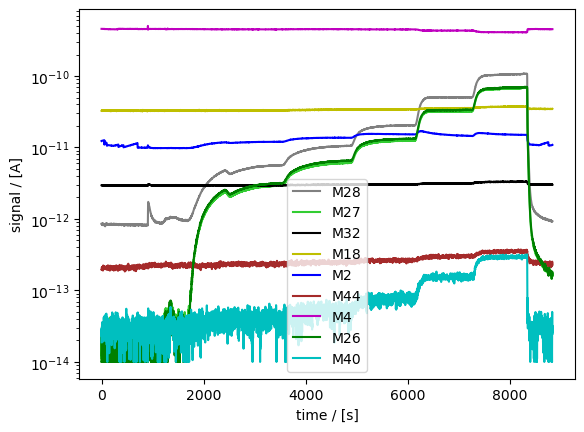

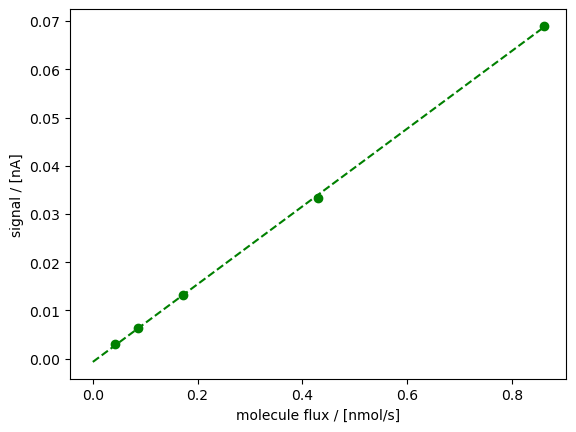

In [22]:
#oxygen
meas_gascal_O2 = Measurement.read(data_dir / "2022-07-20 15_32_25 gas_cal_O2.tsv", reader="zilien", technique="MS")

axes_g = meas_gascal_O2.plot_measurement()

cal_O2_2, ax_h = meas_gascal_O2.gas_flux_calibration_curve(
    inlet=chip,  # the mass spec inlet used in the calibration experiment
    mol="O2",  # the molecule to calibrate
    mass="M32",  # the mass to calibrate at
    tspan_list=[
        [2200, 2300],
        [3500, 3600],
        [4900, 5000],
        [6100, 6200],
        [7300, 7400],
         ], # the timespans to average the signal over
    carrier_mol="He", # the molecule that is used to calculate the total flux through the capillary
    mol_conc_ppm= [5000, 10000, 20000, 50000, 100000], # the concentration of the analyte at the timespans given above in ppm
    tspan_bg=[900, 1000], # the timespan for background subtraction (optional)
    return_ax=True, # whether to return the calibration curve
    #axes_measurement=axes_g # the axis on which to indicate what signal is used with a thicker line  
    #-> this introduces an error into the data analysis (defines that mol_conc_ppm = 10^6) FIXME!! 
)
cal_O2_2.name = "O2_M32_gas"  # so that it doesn't clash with the EC-MS calibration.
print(cal_O2_2) 

#ethylene
meas_gascal_C2H4 = Measurement.read(data_dir / "2022-07-20 13_04_48 gas_cal_C2H4.tsv", reader="zilien", 
                                 technique="MS")

axes_i = meas_gascal_C2H4.plot_measurement()

cal_C2H4, ax_j = meas_gascal_C2H4.gas_flux_calibration_curve(
    inlet=chip,  # the mass spec inlet used in the calibration experiment
    mol="C2H4",  # the molecule to calibrate
    mass="M26",  # the mass to calibrate at
    tspan_list=[
        [3200, 3400],
        [4400, 4600],
        [5800, 6000],
        [6900, 7100],
        [8000, 8200],
         ], # the timespans to average the signal over
    carrier_mol="He", # the molecule that is used to calculate the total flux through the capillary
    mol_conc_ppm= [5000, 10000, 20000, 50000, 100000], # the concentration of the analyte at the timespans given above in ppm
    tspan_bg=[900, 1000], # the timespan for background subtraction (optional)
    return_ax=True, # whether to return the calibration curve
    #axes_measurement=axes_i # the axis on which to indicate what signal is used with a thicker line  
    #-> this introduces an error into the data analysis (defines that mol_conc_ppm = 10^6) FIXME!! 
)
print(cal_C2H4)

# add these gas calibrations to the list:
cal_results.append(cal_O2_2)
cal_results.append(cal_C2H4)


Saving the calibration
-------------------------------

We might want to use the calibration for other measurements later, so let's create an ``ECMSCalibration`` object and save the calibration.

In [23]:
from ixdat.techniques.ec_ms import ECMSCalibration

# Now we put all these results together in an ECMSCalibration object:
calibration = ECMSCalibration(
    name="SI_quant_appnote_calibration",  # Named for the article
    date="22-07-20",  # date of the calibration measurements
    setup="SI R&D1",  # setup where calibration was made
    ms_cal_results=cal_results,  # the mass spec calibrations
    RE_vs_RHE=0,  # the RE potential in [V]
    A_el=0.197,  # the geometric electrode area in [cm^2]
)

This calibration can then be saved using an in-built method, which creates an automatically named calibration file in the same folder as the Jupyter Notebook: "SI_quant_appnote_calibration.ix". This file is human readable, i.e. if you would like to look up sensitivity factors without using ``ixdat`` you can simply open this file in a text editor of your choice.

In [24]:
calibration.export()

 Go ahead and have a look at the file before continuing the rest of the tutorial!

Applying a calibration to your dataset
------------------------------------------------------

In the following we will explore how to apply the EC-MS calibration we determined above to a dataset. There are several ways of how you can pass a calibration to an ``ECMSMeasurement`` objects. We will only address two ways here.

Let's start by loading the calibration object that we saved earlier, as well as loading some uncalibrated data and plotting it.

skipping the following line:
ixdat version = 0.2.7.dev1

skipping the following line:
backend_name = BackendBase(none, address=none)



[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='Ewe/V'>,
 None,
 <Axes: ylabel='<I>/mA'>]

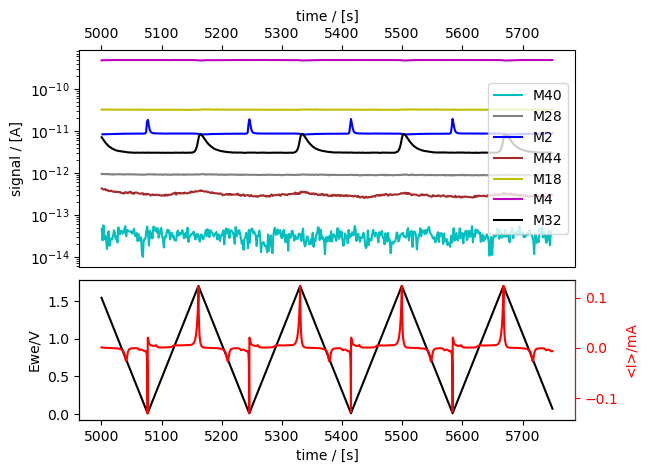

In [25]:
loaded_cal = ECMSCalibration.read(
    "./SI_quant_appnote_calibration.ix"
)

good_bit = Measurement.read(
    "the_good_bit.csv", reader="ixdat", technique = "EC-MS"
)
good_bit.plot_measurement()

And apply the calibration on the data:

[MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.33788342934494986), MSCalResult(name=O2@M32, mol=O2, mass=M32, F=0.10473806185860812), MSCalResult(name=H2_M2_gas, mol=H2, mass=M2, F=0.3191356304426368), MSCalResult(name=O2_M32_gas, mol=O2, mass=M32, F=0.09198714869342346), MSCalResult(name=C2H4@M26, mol=C2H4, mass=M26, F=0.08057166014411676)]


[<Axes: xlabel='time / [s]', ylabel='signal / [A]'>,
 <Axes: xlabel='time / [s]', ylabel='$U_{RHE}$ / [V]'>,
 None,
 <Axes: ylabel='J / [mA cm$^{-2}$]'>]

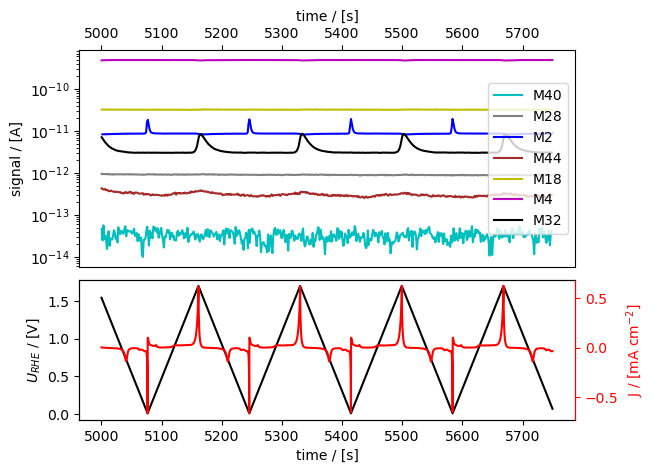

In [26]:
good_bit.add_calibration(loaded_cal)

# Check the MS calibration most recently added to the data
print(good_bit.calibration_list[0].ms_cal_results)

good_bit.plot_measurement()
# good_bit.plot() # gives the same output as plot_measurement() here

As we only provide the calibration for some of the masses, the standard plot is still showing uncalibrated MS data. If we pass the list of molecules where we do have a calibration, then ``plot_measurement()`` will plot the calibrated fluxes instead.

[<Axes: xlabel='time / [s]', ylabel='signal / [mol/s]'>,
 <Axes: xlabel='time / [s]', ylabel='$U_{RHE}$ / [V]'>,
 None,
 <Axes: ylabel='J / [mA cm$^{-2}$]'>]

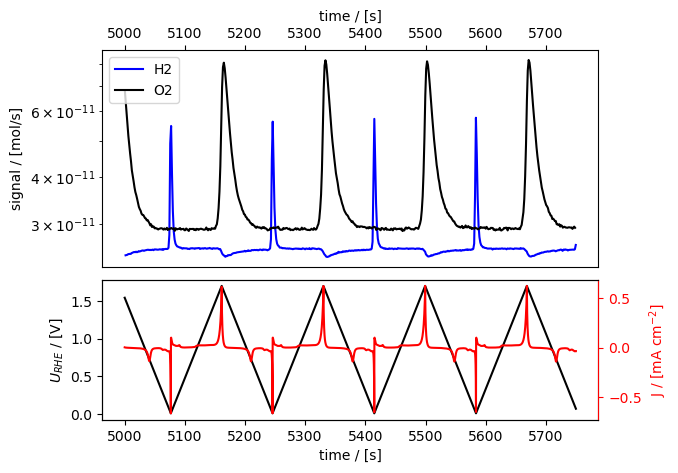

In [27]:
good_bit.plot_measurement(mol_list=["H2", "O2"])

Alternatively, if we calculate the calibration factors in the same ``ixdat`` session as our data treatment, we can also directly apply the calibration without having to create the calibration object first. In this way, we can also make sure that we use a specific calibration factor if we have determined several for one analyte.

In [28]:
# Lets import the file again, so we can be sure there's no calibration attached yet
good_bit2 = Measurement.read(
    "the_good_bit.csv", reader="ixdat", technique="EC-MS"
)
# Add the EC calibration first
good_bit2.calibrate(RE_vs_RHE=0, A_el=0.197)

# Let's check what MS calibrations we have saved in our list
print(cal_results)

skipping the following line:
ixdat version = 0.2.7.dev1

skipping the following line:
backend_name = BackendBase(none, address=none)

[MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.33788342934494986), MSCalResult(name=O2@M32, mol=O2, mass=M32, F=0.10473806185860812), MSCalResult(name=H2_M2_gas, mol=H2, mass=M2, F=0.3191356304426368), MSCalResult(name=O2_M32_gas, mol=O2, mass=M32, F=0.09198714869342346), MSCalResult(name=C2H4@M26, mol=C2H4, mass=M26, F=0.08057166014411676)]


[MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.33788342934494986), MSCalResult(name=O2_M32_gas, mol=O2, mass=M32, F=0.09198714869342346)]


[<Axes: xlabel='time / [s]', ylabel='signal / [mol/s]'>,
 <Axes: xlabel='time / [s]', ylabel='$U_{RHE}$ / [V]'>,
 None,
 <Axes: ylabel='J / [mA cm$^{-2}$]'>]

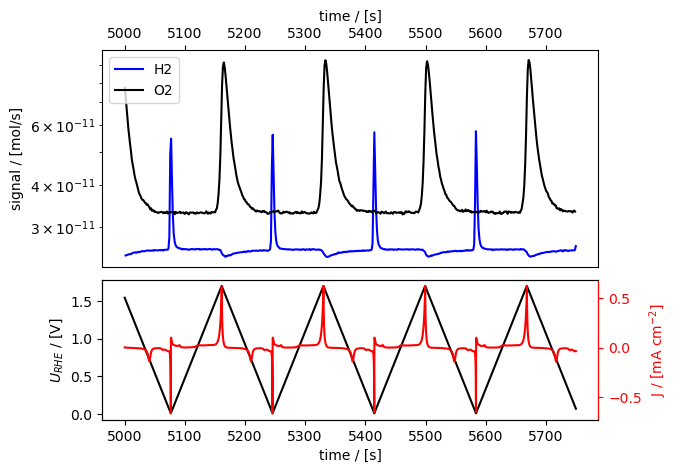

In [29]:
# Let's calibrate using the EC-MS calibration for hydrogen and the gas calibration for oxygen
good_bit2.calibrate(ms_cal_results=[cal_results[0], cal_results[3]])

# Check the calibration most recently added to the data
print(good_bit2.calibration_list[0].ms_cal_results)

# And plot it once again:
good_bit2.plot_measurement(mol_list=["H2", "O2"])

Plotting calibrated EC-MS data
=========================

Now that we've calibrated the data, we want to make some nice plots. In the sections below, we will explore some ways of using ixdat's plotter and modify the plots using matplotlib.

EC-MS plot calibrated gases using two y axes
-----------------------------------------------------------------

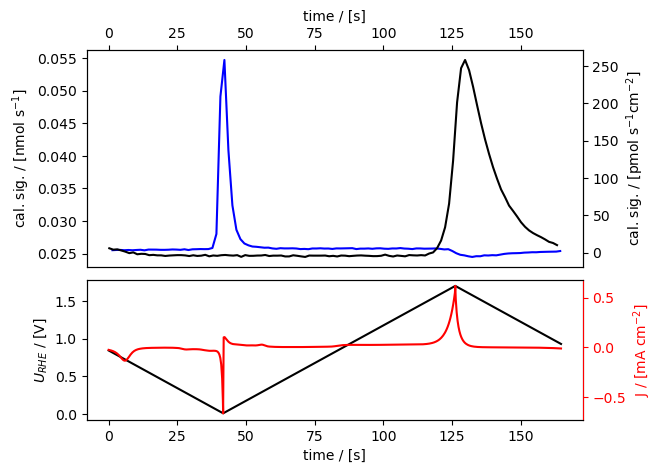

In [30]:
meas_a = good_bit.cut(tspan=[5035, 5200]) #cut the data to the interesting section
meas_a.tstamp += meas_a.t[0]  #to get the figure showing the time starting at 0

axes_a = meas_a.plot_measurement(
    mol_lists=[
        ["H2"],  # left y-axis
        ["O2"],  # right
    ],
    tspan_bg=[
        None,
        [0, 20],
    ],  # [left, right] y-axes
    unit=["nmol/s", "pmol/s/cm^2"],  # [left, right] y-axes
    logplot=False,
    legend=False, # e.g. if you want to add labels to the figure manually later
)
axes_a[0].set_ylabel("cal. sig. / [nmol s$^{-1}$]")
axes_a[2].set_ylabel("cal. sig. / [pmol s$^{-1}$cm$^{-2}$]")

fig_a = axes_a[0].get_figure()
fig_a.savefig("fig_a.png")

 --- Cyclic voltammetry MS plot of two of the cycles ---

C:\Users\Søren\git\ixdat\src\ixdat\plotters\ms_plotter.py:279: UserWarning: Can't convert original unit '' to new unit 'None'. Plotting using original unit 'None' with unit_factor=1 (one).
  x_unit_factor, x_unit = self._get_x_unit_factor(
C:\Users\Søren\git\ixdat\src\ixdat\plotters\ms_plotter.py:279: UserWarning: Can't convert original unit '' to new unit ''. Plotting using original unit '' with unit_factor=1 (one).
  x_unit_factor, x_unit = self._get_x_unit_factor(


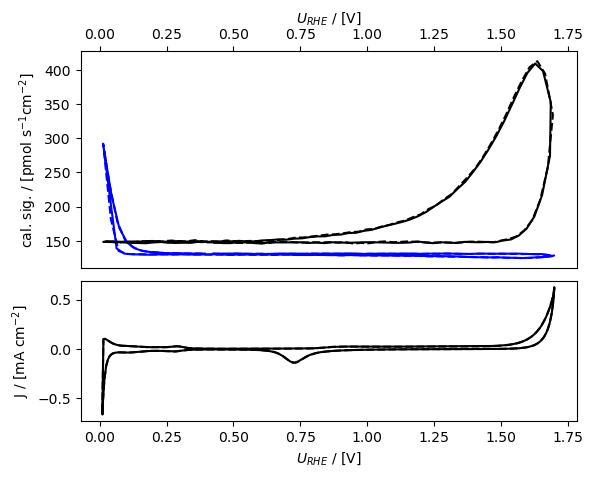

In [31]:
meas_b = good_bit.as_cv() #by defining it as cv, meas_b.plot() would automatically plot vs potential
#as soon as it's CV you can index by "cycle"
meas_b.redefine_cycle(start_potential=0.4, redox=1)
#now you can choose where a cycle starts, here defined as potential = 0.4, anodic/oxidizing = 1 (or True), cathodic/reducing = 0 (or False)
#probably the syntax is inspired by biologic data, but it actually has nothing to do with the old biologic data
#initial cycle is 0, first time the set condition is met, starts cycle 1 etc.

axes_b = meas_b[1].plot_vs_potential(
    mol_list=["H2", "O2"],
    unit="pmol/s/cm^2",
    logplot=False,
    legend=False,
    remove_background=True, #should remove the minimum value from the cut dataset, but it is possible somewhere to actually 
    # the background (possibly where you define the dataset)
)
meas_b[3].plot_vs_potential(
    mol_list=["H2", "O2"],
    unit="pmol/s/cm^2",
    logplot=False,
    legend=False,
    remove_background=True,
    axes=axes_b, #to reuse the axis for co-plotting two separate parts of the measurement
    linestyle="--",
)
axes_b[0].set_ylabel("cal. sig. / [pmol s$^{-1}$cm$^{-2}$]")
axes_b[0].set_xlabel(meas_b.U_name)

fig_b = axes_b[0].get_figure()
fig_b.savefig("fig_b.png")

EC-MS plot with carrier gases on right y-axis (uncalibrated) and products on left (calibrated)
-----------------------------------------------------------------------------------------------------------------------------------
Note that it is possible to mix calibrated and uncalibrated data by calling the plotting function twice. This enables one to plot the uncalibrated carrier gas signal  on one y-axis (which may carry information about how the experiment was done even if it is not itself quantified) and the product signal on the other y-axis. It is even possible to plot the data on a logarithmic scale on one axis, and a linear scale on the other axis, as shown below.

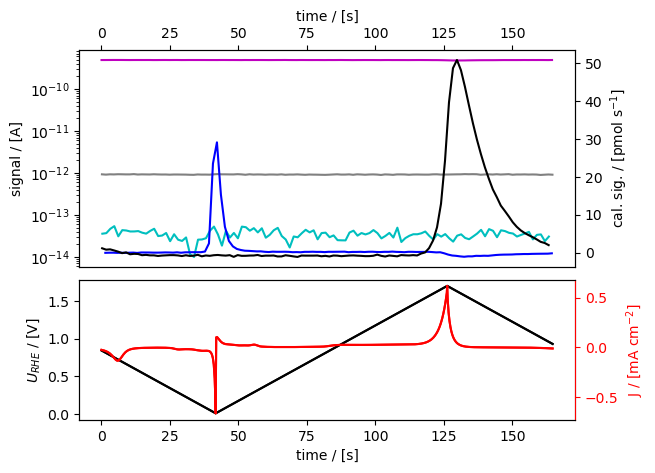

In [32]:
meas_c = good_bit.cut(tspan=[5035, 5200])
meas_c.tstamp += meas_c.t[0]

meas_c.set_bg(
   tspan_bg=[0, 20], mass_list=["M2", "M32"]
)

axes_c = meas_c.plot_measurement(
    mol_lists=[[], ["H2", "O2"]], # right y-axis
    unit="pmol/s",
    logplot=False,
    legend=False,
)
meas_c.plot_measurement(
   mass_list=["M4", "M28", "M40"],  # left y-axis
    #unit=["nmol/s"],  # [left, right] y-axes
    logplot=True,
    legend=False,
    axes=axes_c, #to reuse the axis for co-plotting two separate parts of the measurement
    #linestyle="--",
)
axes_c[2].set_ylabel("cal. sig. / [pmol s$^{-1}$]")

fig_c = axes_c[0].get_figure()
fig_c.savefig("fig_c.png")

EC-MS plot with a third with system parameters added
-----------------------------------------------------------------------------

In some cases it can be interesting to co-plot some other data, e.g. system parameters like iongauge pressure or MFC flow rates. Let's have a look at the iongauge pressure during one of the CV cycles and plot that in a third panel of our regular EC-MS plots.

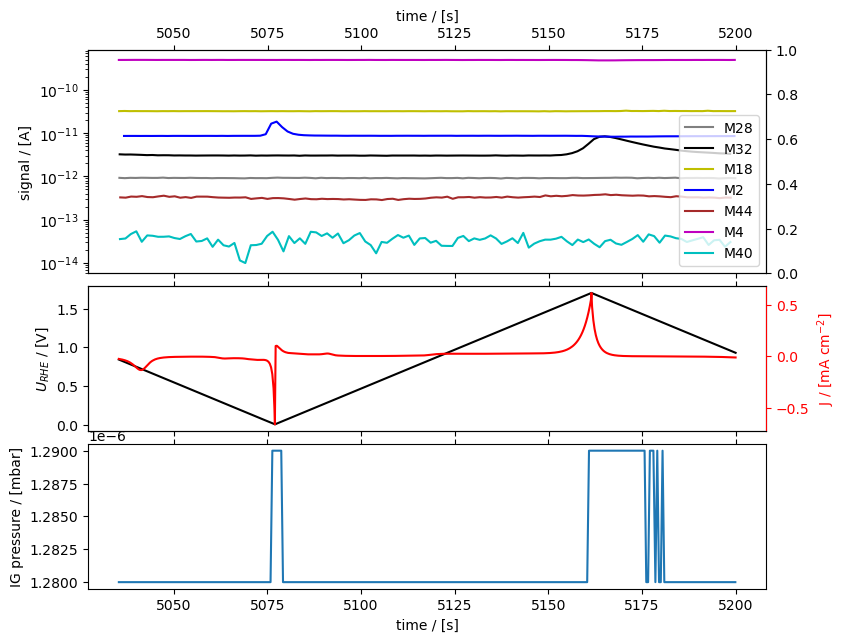

In [33]:
from matplotlib import pyplot as plt
from matplotlib import gridspec

# since we want to co-plot system parameters here, which were not part of the exported dataset, we need to use another version
# of our dataset # imported above, which hasn't been calibrated yet, so let's quickly calibrate that now
meas_part.add_calibration(loaded_cal)


# cut the relevant part from a big dataset
meas_d = meas_part.cut(tspan=[5035, 5200])

# grab the iongauge pressure
ig1 = meas_d.grab("Iongauge value [mbar]")

# create a figure with 3 panels
fig_4 = plt.figure()
gs = gridspec.GridSpec(7, 1, fig_4)
ax_ms = plt.subplot(gs[0:3, 0]) # MS signals panel
ax_ms_right = ax_ms.twinx()     # right axis for the MS signals, not used here
ax_ec = plt.subplot(gs[3:5, 0]) # EC signals panel
ax_ec_right = ax_ec.twinx()     # axis for the current
ax_ig= plt.subplot(gs[5:7, 0]) # Ion Gauge panel
fig_4.set_figheight(7)
fig_4.set_figwidth(fig_4.get_figheight() * 1.25)

ax_ms.tick_params(
    axis="x", top=True, bottom=True, labeltop=True, labelbottom=False
)
ax_ec.tick_params(
    axis="x", top=True, bottom=True, labeltop=False, labelbottom=False
)
ax_ig.tick_params(
    axis="x", top=True, bottom=True, labeltop=False, labelbottom=True
)

ax_ms.set_xlabel("time / [s]")
ax_ms.xaxis.set_label_position("top")

ax_ig.set_xlabel("time / [s]")
ax_ig.set_ylabel("IG pressure / [mbar]")
ax_ms.set_ylabel("Signal / [A]")
ax_ms.set_yscale("log")


ax_ec.set_ylabel("U$_{RHE}$ / (V)")
ax_ec_right.set_ylabel("J$_{total}$ / (mA cm$^{-2}$)", color="red")


# add the MS and EC data to the correct axes using ixdat's "plot measurement"
meas_d.plot_measurement(axes=[ax_ms, ax_ec, ax_ms_right, ax_ec_right])
# this overwrites some of the axis labels, so we need to define them (again) if we want them non-standard
ax_ec.set_xlabel("")
ax_ec_right.set_xlabel("")

# add the iongauge data from the "grabbed" data series
ax_ig.plot(ig1[0], ig1[1])

Congratulations! You have reached the end of this tutorial and are now an expert in loading, calibrating and plotting EC-MS data using ``ixdat``.